##### Source: #####
1. https://www.kaggle.com/datasets/shreyasi2002/vgg16-models-mnist-fashion-mnist
2. http://yann.lecun.com/exdb/mnist/
3. https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [6]:
# !pip -q install torch torchvision tqdm matplotlib pandas

import os, random, math, copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)


DEVICE: cpu


In [ ]:
maindata = {
    "mnist_path": "mnist_path",   
    "dataset": "mnist",            
    "batch_size": 128,
    "epochs_clean": 6,
    "epochs_advtrain": 4,
    "epochs_ae": 6,
    "lr": 1e-3,
    "fgsm_eps": 0.2,
    "seed": 42,
    "cache_dir": "mnist_path/fgsm_cache",  
}

In [ ]:
def get_dataloaders(dataset_name: str, root: str, batch_size: int):
    # pad 2px: 28x28 -> 32x32
    tfm = transforms.Compose([transforms.Resize(32), transforms.ToTensor()])

    if dataset_name == "mnist":
        train_ds = datasets.MNIST(root=root, train=True, transform=tfm, download=False)
        test_ds  = datasets.MNIST(root=root, train=False, transform=tfm, download=False)
        mean, std = 0.1307, 0.3081
    elif dataset_name == "fashion":
        train_ds = datasets.FashionMNIST(root=root, train=True, transform=tfm, download=False)
        test_ds  = datasets.FashionMNIST(root=root, train=False, transform=tfm, download=False)
        mean, std = 0.2860, 0.3530
    else:
        raise ValueError("dataset must be 'mnist' or 'fashion'")

    pin = (DEVICE == "cuda")
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=pin)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=pin)
    return train_loader, test_loader, (mean, std)

train_loader, test_loader, (MEAN, STD) = get_dataloaders(maindata['dataset'], maindata['mnist_path'], maindata['batch_size'])
print("mean/std:", MEAN, STD)


mean/std: 0.1307 0.3081


In [ ]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

def plot_params_vs_metric(models, names=None, metric=None, metric_name="Test accuracy"):
    """
    models: list of torch.nn.Module
    names: list[str] (optional)
    metric: list[float] (optional) same length as models (например test_acc)
    Рисует:
      - столбцы параметров
      - если metric задана: scatter params vs metric + отмечает "opt" по metric/log10(params)
    """
    if names is None:
        names = [f"model_{i}" for i in range(len(models))]

    totals = []
    trains = []
    for m in models:
        t, tr = count_params(m)
        totals.append(t)
        trains.append(tr)

    x = np.arange(len(models))
    plt.figure(figsize=(8, 4))
    plt.bar(x, totals, label="Total params")
    if any(tr != t for tr, t in zip(trains, totals)):
        plt.bar(x, trains, label="Trainable params")
    plt.xticks(x, names, rotation=20, ha="right")
    plt.ylabel("Number of parameters")
    plt.title("Model parameter counts")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()




## Модели VGG16 + my VGGLite

In [10]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor([mean]).view(1,1,1,1))
        self.register_buffer("std",  torch.tensor([std]).view(1,1,1,1))

    def forward(self, x):
        return (x - self.mean) / self.std

class WrapWithNorm(nn.Module):
    def __init__(self, backbone: nn.Module, mean: float, std: float):
        super().__init__()
        self.norm = Normalize(mean, std)
        self.backbone = backbone

    def forward(self, x):
        return self.backbone(self.norm(x))


In [ ]:
class VGGBlock(nn.Module):
    def __init__(self, in_ch, out_ch, n_convs):
        super().__init__()
        layers = []
        ch = in_ch
        for _ in range(n_convs):
            layers += [
                nn.Conv2d(ch, out_ch, 3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            ]
            ch = out_ch
        layers += [nn.MaxPool2d(2)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

# "VGG16" под 32x32: 5 pooling -> 1x1
class VGG16_MNIST(nn.Module):
    def __init__(self, num_classes=10, in_ch=1):
        super().__init__()
        self.features = nn.Sequential(
            VGGBlock(in_ch, 64, 2),
            VGGBlock(64, 128, 2),
            VGGBlock(128, 256, 3),
            VGGBlock(256, 512, 3),
            VGGBlock(512, 512, 3),
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)

class MyVGG_Lite(nn.Module):
    def __init__(self, num_classes=10, in_ch=1, base=32):
        super().__init__()
        self.features = nn.Sequential(
            VGGBlock(in_ch, base, 2),       # 32
            VGGBlock(base, base*2, 2),      # 64
            VGGBlock(base*2, base*4, 3),    # 128
            VGGBlock(base*4, base*8, 3),    # 256
        )
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(base*8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        return self.classifier(x)


## Обучение/оценка + графики

In [ ]:
@torch.no_grad()
def accuracy_from_logits(logits, y):
    return (logits.argmax(1) == y).float().mean().item()

def train_one_epoch(model, loader, optimizer):
    model.train()
    losses, accs = [], []
    pbar = tqdm(loader, desc="train", leave=False)
    for x, y in pbar:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits.detach(), y))
        pbar.set_postfix(loss=float(np.mean(losses)), acc=float(np.mean(accs)))
    return float(np.mean(losses)), float(np.mean(accs))

@torch.no_grad()
def eval_clean(model, loader):
    model.eval()
    losses, accs = [], []
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        losses.append(F.cross_entropy(logits, y).item())
        accs.append(accuracy_from_logits(logits, y))
    return float(np.mean(losses)), float(np.mean(accs))

def fit(model, train_loader, test_loader, epochs, lr):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
    for ep in range(1, epochs+1):
        tr_l, tr_a = train_one_epoch(model, train_loader, opt)
        te_l, te_a = eval_clean(model, test_loader)
        hist["train_loss"].append(tr_l)
        hist["train_acc"].append(tr_a)
        hist["test_loss"].append(te_l)
        hist["test_acc"].append(te_a)
        print(f"Epoch {ep:02d}/{epochs} | train acc={tr_a:.4f} loss={tr_l:.4f} | test acc={te_a:.4f} loss={te_l:.4f}")
    return model, hist

def plot_history(hist, title):
    xs = np.arange(1, len(hist["train_loss"])+1)
    plt.figure(figsize=(7,4))
    plt.plot(xs, hist["train_loss"], label="train_loss")
    plt.plot(xs, hist["test_loss"],  label="test_loss")
    plt.title(title + " | loss")
    plt.grid(True)
    plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(xs, hist["train_acc"], label="train_acc")
    plt.plot(xs, hist["test_acc"],  label="test_acc")
    plt.title(title + " | accuracy")
    plt.grid(True) 
    plt.legend()
    plt.show()


## FGSM-атака

In [13]:
os.makedirs(maindata['cache_dir'], exist_ok=True)
def fgsm_attack(model, x, y, eps):
    x_adv = x.clone().detach().to(DEVICE)
    y = y.to(DEVICE)
    x_adv.requires_grad_(True)

    logits = model(x_adv)
    loss = F.cross_entropy(logits, y)
    model.zero_grad(set_to_none=True)
    loss.backward()

    x_adv = x_adv + eps * x_adv.grad.detach().sign()
    return x_adv.clamp(0.0, 1.0).detach()

@torch.no_grad()
def eval_on_loader(model, loader, defense_fn=None):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        if defense_fn is not None:
            x = defense_fn(x)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return correct / total

def build_fgsm_dataset(model, base_loader, eps, save_path):
    """
    Делает отдельную "атакованную базу" (TensorDataset) и сохраняет в save_path.
    Если файл уже есть — просто загружает.
    """
    if os.path.exists(save_path):
        data = torch.load(save_path, map_location="cpu")
        return TensorDataset(data["x_adv"], data["y"])

    model.eval()
    xs_adv, ys = [], []
    for x, y in tqdm(base_loader, desc=f"build_fgsm eps={eps}", leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        with torch.enable_grad():
            x_adv = fgsm_attack(model, x, y, eps)
        xs_adv.append(x_adv.cpu())
        ys.append(y.cpu())

    x_adv = torch.cat(xs_adv, dim=0)
    y_all = torch.cat(ys, dim=0)

    torch.save({"x_adv": x_adv, "y": y_all}, save_path)
    return TensorDataset(x_adv, y_all)


## Защита Adversarial Training & Denoising Conv-AutoEncoder

In [14]:
def train_one_epoch_advtrain(model, loader, optimizer, eps, adv_ratio=0.5):
    model.train()
    losses, accs = [], []
    pbar = tqdm(loader, desc="adv-train", leave=False)
    for x, y in pbar:
        x, y = x.to(DEVICE), y.to(DEVICE)

        model.eval()
        with torch.enable_grad():
            x_adv = fgsm_attack(model, x, y, eps)
        model.train()

        n = x.size(0)
        k = int(n * adv_ratio)
        x_mix = torch.cat([x[:n-k], x_adv[n-k:]], dim=0)
        y_mix = torch.cat([y[:n-k], y[n-k:]], dim=0)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x_mix)
        loss = F.cross_entropy(logits, y_mix)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accs.append(accuracy_from_logits(logits.detach(), y_mix))
        pbar.set_postfix(loss=float(np.mean(losses)), acc=float(np.mean(accs)))
    return float(np.mean(losses)), float(np.mean(accs))

def fit_advtrain(model, train_loader, test_loader, epochs, lr, eps):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = {"train_loss":[], "train_acc":[], "test_loss":[], "test_acc":[]}
    for ep in range(1, epochs+1):
        tr_l, tr_a = train_one_epoch_advtrain(model, train_loader, opt, eps=eps, adv_ratio=0.5)
        te_l, te_a = eval_clean(model, test_loader)
        hist["train_loss"].append(tr_l); hist["train_acc"].append(tr_a)
        hist["test_loss"].append(te_l);  hist["test_acc"].append(te_a)
        print(f"[ADV] Epoch {ep:02d}/{epochs} | train acc={tr_a:.4f} loss={tr_l:.4f} | test acc={te_a:.4f} loss={te_l:.4f}")
    return model, hist


In [15]:
class DenoiseAE(nn.Module):
    def __init__(self, in_ch=1, latent_noise=0.05):
        super().__init__()
        self.latent_noise = latent_noise

        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        )
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 2, stride=2), nn.ReLU(),  # 16x16
            nn.ConvTranspose2d(64, 32, 2, stride=2), nn.ReLU(),   # 32x32
            nn.Conv2d(32, in_ch, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.enc(x)
        if self.training and self.latent_noise > 0:
            z = z + self.latent_noise * torch.randn_like(z)
        return self.dec(z)

def train_ae(ae, classifier, loader, eps, epochs=5, lr=1e-3):
    ae = ae.to(DEVICE)
    classifier.eval()
    opt = torch.optim.Adam(ae.parameters(), lr=lr)

    for ep in range(1, epochs+1):
        ae.train()
        mses = []
        for x, y in tqdm(loader, desc=f"AE epoch {ep}/{epochs}", leave=False):
            x, y = x.to(DEVICE), y.to(DEVICE)
            with torch.enable_grad():
                x_adv = fgsm_attack(classifier, x, y, eps)

            opt.zero_grad(set_to_none=True)
            x_rec = ae(x_adv)
            mse = F.mse_loss(x_rec, x)
            mse.backward()
            opt.step()
            mses.append(mse.item())
        print(f"AE epoch {ep:02d}/{epochs} | mse={float(np.mean(mses)):.6f}")
    return ae

@torch.no_grad()
def defense_fn_from_ae(ae):
    ae.eval()
    def _fn(x):
        return ae(x)
    return _fn



=== TRAIN CLEAN: VGG16 ===


Epoch 01/6 | train acc=0.8937 loss=0.3157 | test acc=0.9800 loss=0.0713


Epoch 02/6 | train acc=0.9819 loss=0.0675 | test acc=0.9845 loss=0.0580


Epoch 03/6 | train acc=0.9870 loss=0.0464 | test acc=0.9894 loss=0.0411


Epoch 04/6 | train acc=0.9890 loss=0.0406 | test acc=0.9894 loss=0.0385


Epoch 05/6 | train acc=0.9905 loss=0.0348 | test acc=0.9944 loss=0.0219


Epoch 06/6 | train acc=0.9925 loss=0.0294 | test acc=0.9897 loss=0.0410


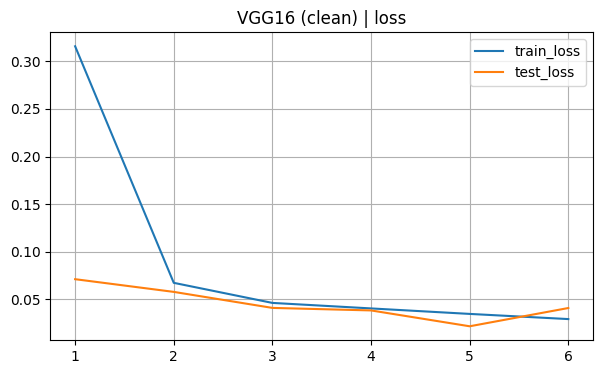

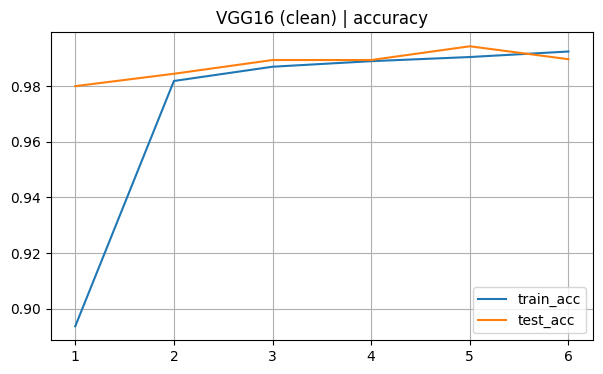


=== TRAIN CLEAN: MyNet ===


Epoch 01/6 | train acc=0.9696 loss=0.1070 | test acc=0.9891 loss=0.0309


Epoch 02/6 | train acc=0.9885 loss=0.0401 | test acc=0.9875 loss=0.0408


Epoch 03/6 | train acc=0.9914 loss=0.0309 | test acc=0.9934 loss=0.0237


Epoch 04/6 | train acc=0.9924 loss=0.0253 | test acc=0.9919 loss=0.0281


Epoch 05/6 | train acc=0.9932 loss=0.0237 | test acc=0.9905 loss=0.0314


Epoch 06/6 | train acc=0.9938 loss=0.0209 | test acc=0.9897 loss=0.0298


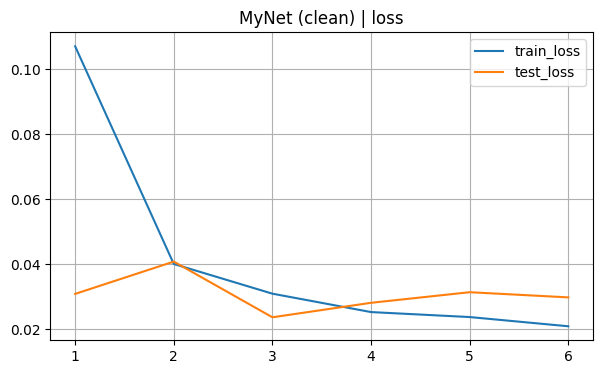

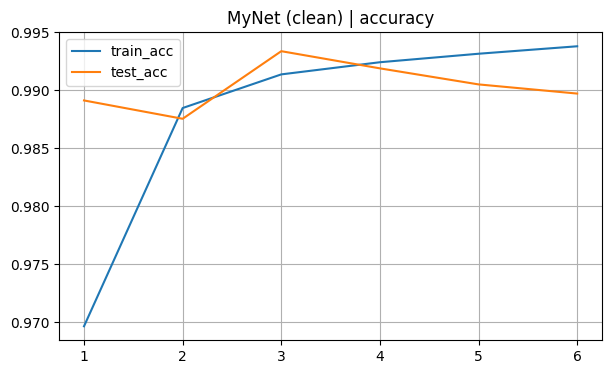


=== RESULTS (NO DEFENSE) ===
VGG16: clean=0.9897 | FGSM=0.0201
MyNet: clean=0.9897  | FGSM=0.1224


In [ ]:

vgg16 = WrapWithNorm(VGG16_MNIST(num_classes=10, in_ch=1), MEAN, STD)
my_net = WrapWithNorm(MyVGG_Lite(num_classes=10, in_ch=1, base=32), MEAN, STD)

print("\n=== TRAIN CLEAN: VGG16 ===")
vgg16, hist_vgg = fit(vgg16, train_loader, test_loader, maindata["epochs_clean"], maindata["lr"])
plot_history(hist_vgg, "VGG16 (clean)")

print("\n=== TRAIN CLEAN: MyNet ===")
my_net, hist_my = fit(my_net, train_loader, test_loader, maindata["epochs_clean"], maindata["lr"])
plot_history(hist_my, "MyNet (clean)")

acc_vgg_clean = hist_vgg["test_acc"][-1]
acc_my_clean  = hist_my["test_acc"][-1]

# делаем ОТДЕЛЬНУЮ FGSM "базу" (на тесте) и меряем accuracy
vgg_fgsm_path = os.path.join(maindata["cache_dir"], f"fgsm_test_vgg_eps{maindata['fgsm_eps']:.2f}.pt")
my_fgsm_path  = os.path.join(maindata["cache_dir"], f"fgsm_test_my_eps{maindata['fgsm_eps']:.2f}.pt")

fgsm_test_ds_vgg = build_fgsm_dataset(vgg16, test_loader, maindata["fgsm_eps"], vgg_fgsm_path)
fgsm_test_ds_my  = build_fgsm_dataset(my_net, test_loader, maindata["fgsm_eps"], my_fgsm_path)

fgsm_test_loader_vgg = DataLoader(fgsm_test_ds_vgg, batch_size=maindata["batch_size"], shuffle=False, num_workers=0)
fgsm_test_loader_my  = DataLoader(fgsm_test_ds_my,  batch_size=maindata["batch_size"], shuffle=False, num_workers=0)

acc_vgg_fgsm = eval_on_loader(vgg16, fgsm_test_loader_vgg)
acc_my_fgsm  = eval_on_loader(my_net, fgsm_test_loader_my)

print("\n=== RESULTS (NO DEFENSE) ===")
print(f"VGG16: clean={acc_vgg_clean:.4f} | FGSM={acc_vgg_fgsm:.4f}")
print(f"MyNet: clean={acc_my_clean:.4f}  | FGSM={acc_my_fgsm:.4f}")


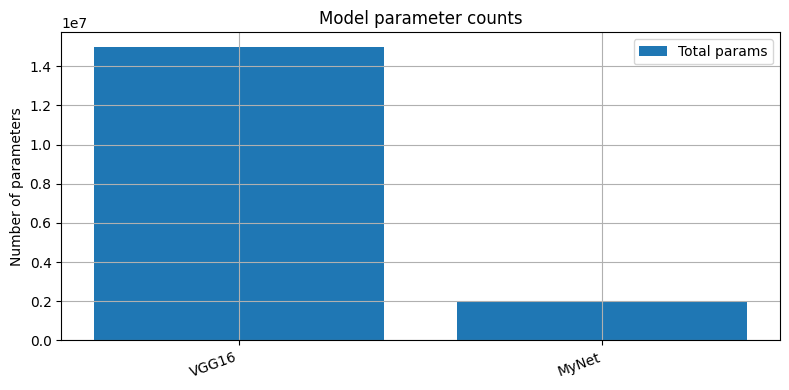

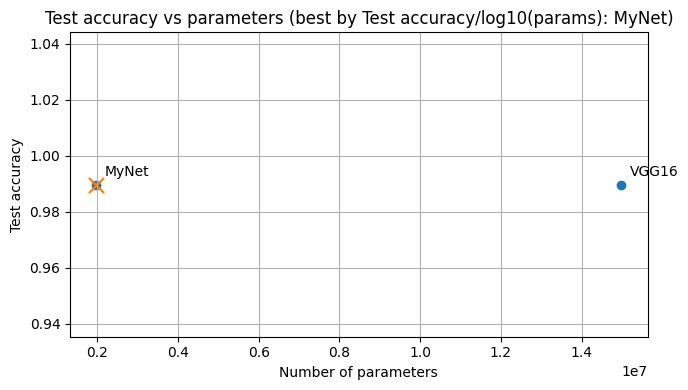

=== Summary ===
       VGG16: params=14,985,546 | Test accuracy=0.9897 | score=0.1379
       MyNet: params=1,979,050 | Test accuracy=0.9897 | score=0.1572

OPTIMAL (proxy): MyNet  (params=1,979,050, Test accuracy=0.9897)


In [17]:
models = [vgg16, my_net]  # ваши модели
names = ["VGG16", "MyNet"]
metric = [acc_vgg_clean, acc_my_clean]  # например test_acc на чистых данных
plot_params_vs_metric(models, names=names, metric=metric, metric_name="Test accuracy")


=== ADV TRAIN: VGG16 ===


[ADV] Epoch 01/4 | train acc=0.9625 loss=0.1365 | test acc=0.9836 loss=0.0602


[ADV] Epoch 02/4 | train acc=0.9906 loss=0.0340 | test acc=0.9917 loss=0.0283


[ADV] Epoch 03/4 | train acc=0.9917 loss=0.0318 | test acc=0.9910 loss=0.0332


[ADV] Epoch 04/4 | train acc=0.9929 loss=0.0263 | test acc=0.9914 loss=0.0346


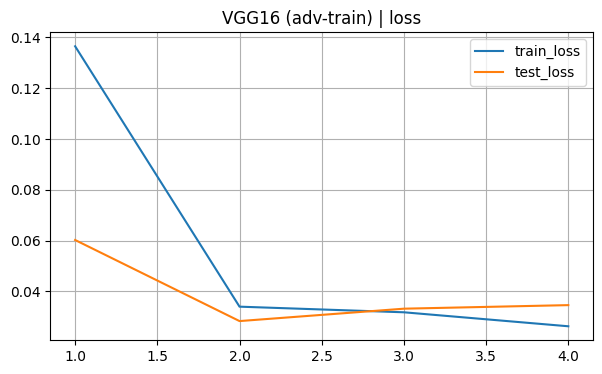

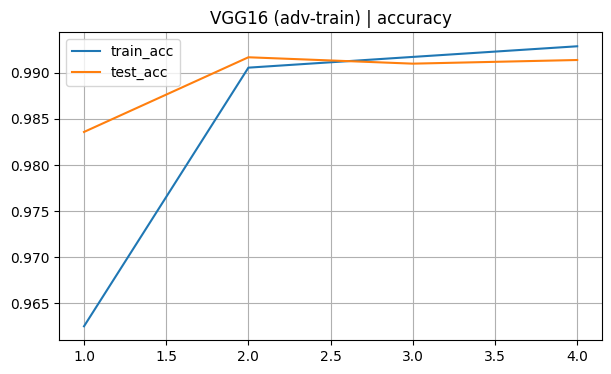


=== ADV TRAIN: MyNet ===


[ADV] Epoch 01/4 | train acc=0.9680 loss=0.1098 | test acc=0.9940 loss=0.0223


[ADV] Epoch 02/4 | train acc=0.9937 loss=0.0203 | test acc=0.9916 loss=0.0300


[ADV] Epoch 03/4 | train acc=0.9943 loss=0.0182 | test acc=0.9926 loss=0.0251


[ADV] Epoch 04/4 | train acc=0.9950 loss=0.0166 | test acc=0.9826 loss=0.0643


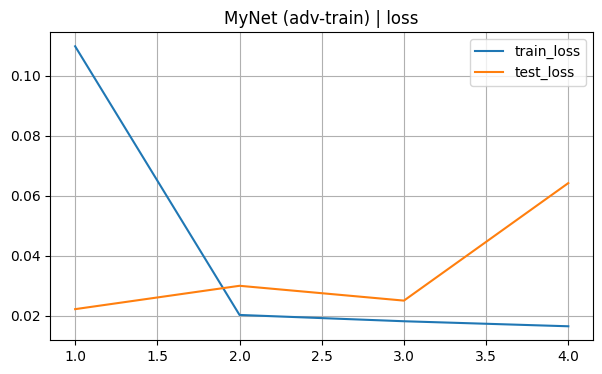

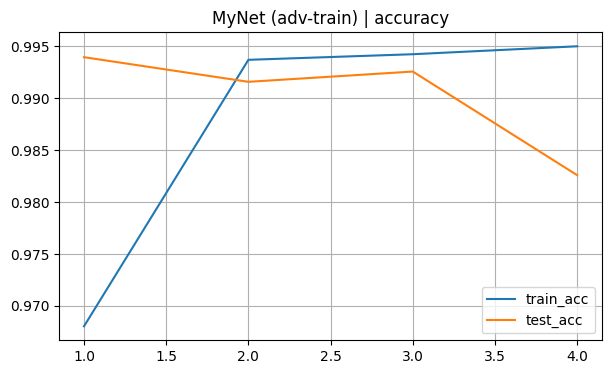


=== RESULTS (ADVERSARIAL TRAINING) ===
VGG16_ADV: clean=0.9914 | FGSM=0.9951
MyNet_ADV: clean=0.9826  | FGSM=0.9912


In [ ]:
# копии моделей (чтобы не портить "чистую" версию)
vgg_adv = copy.deepcopy(vgg16)
my_adv  = copy.deepcopy(my_net)

print("\n=== ADV TRAIN: VGG16 ===")
vgg_adv, hist_vgg_adv = fit_advtrain(vgg_adv, train_loader, test_loader,
                                     maindata["epochs_advtrain"], maindata["lr"], maindata["fgsm_eps"])
plot_history(hist_vgg_adv, "VGG16 (adv-train)")

print("\n=== ADV TRAIN: MyNet ===")
my_adv, hist_my_adv = fit_advtrain(my_adv, train_loader, test_loader,
                                   maindata["epochs_advtrain"], maindata["lr"], maindata["fgsm_eps"])
plot_history(hist_my_adv, "MyNet (adv-train)")

# FGSM-база под защищённые модели
vgg_adv_fgsm_path = os.path.join(maindata["cache_dir"], f"fgsm_test_vgg_adv_eps{maindata['fgsm_eps']:.2f}.pt")
my_adv_fgsm_path  = os.path.join(maindata["cache_dir"], f"fgsm_test_my_adv_eps{maindata['fgsm_eps']:.2f}.pt")

fgsm_test_ds_vgg_adv = build_fgsm_dataset(vgg_adv, test_loader, maindata["fgsm_eps"], vgg_adv_fgsm_path)
fgsm_test_ds_my_adv  = build_fgsm_dataset(my_adv,  test_loader, maindata["fgsm_eps"], my_adv_fgsm_path)

fgsm_test_loader_vgg_adv = DataLoader(fgsm_test_ds_vgg_adv, batch_size=maindata["batch_size"], shuffle=False, num_workers=0)
fgsm_test_loader_my_adv  = DataLoader(fgsm_test_ds_my_adv,  batch_size=maindata["batch_size"], shuffle=False, num_workers=0)

acc_vgg_adv_clean = hist_vgg_adv["test_acc"][-1]
acc_my_adv_clean  = hist_my_adv["test_acc"][-1]
acc_vgg_adv_fgsm  = eval_on_loader(vgg_adv, fgsm_test_loader_vgg_adv)
acc_my_adv_fgsm   = eval_on_loader(my_adv,  fgsm_test_loader_my_adv)

print("\n=== RESULTS (ADVERSARIAL TRAINING) ===")
print(f"VGG16_ADV: clean={acc_vgg_adv_clean:.4f} | FGSM={acc_vgg_adv_fgsm:.4f}")
print(f"MyNet_ADV: clean={acc_my_adv_clean:.4f}  | FGSM={acc_my_adv_fgsm:.4f}")


In [19]:
# AE для VGG16_ADV
ae_vgg = DenoiseAE(in_ch=1, latent_noise=0.05)
ae_vgg = train_ae(ae_vgg, vgg_adv, train_loader, maindata["fgsm_eps"], epochs=maindata["epochs_ae"], lr=1e-3)
def_vgg = defense_fn_from_ae(ae_vgg)
acc_vgg_adv_fgsm_denoised = eval_on_loader(vgg_adv, fgsm_test_loader_vgg_adv, defense_fn=def_vgg)

# AE для MyNet_ADV
ae_my = DenoiseAE(in_ch=1, latent_noise=0.05)
ae_my = train_ae(ae_my, my_adv, train_loader, maindata["fgsm_eps"], epochs=maindata["epochs_ae"], lr=1e-3)
def_my = defense_fn_from_ae(ae_my)
acc_my_adv_fgsm_denoised = eval_on_loader(my_adv, fgsm_test_loader_my_adv, defense_fn=def_my)

print("\n=== RESULTS (DENOISING AE on top of ADV-TRAIN) ===")
print(f"VGG16_ADV + AE: FGSM->denoised acc={acc_vgg_adv_fgsm_denoised:.4f}")
print(f"MyNet_ADV + AE: FGSM->denoised acc={acc_my_adv_fgsm_denoised:.4f}")


AE epoch 01/6 | mse=0.103189


AE epoch 02/6 | mse=0.100819


AE epoch 03/6 | mse=0.100825


AE epoch 04/6 | mse=0.100827


AE epoch 05/6 | mse=0.100823


AE epoch 06/6 | mse=0.100826


AE epoch 01/6 | mse=0.103238


AE epoch 02/6 | mse=0.100827


AE epoch 03/6 | mse=0.100822


AE epoch 04/6 | mse=0.100822


AE epoch 05/6 | mse=0.100822


AE epoch 06/6 | mse=0.100822

=== RESULTS (DENOISING AE on top of ADV-TRAIN) ===
VGG16_ADV + AE: FGSM->denoised acc=0.1135
MyNet_ADV + AE: FGSM->denoised acc=0.1135



--- VGG16_ADV + AE samples ---


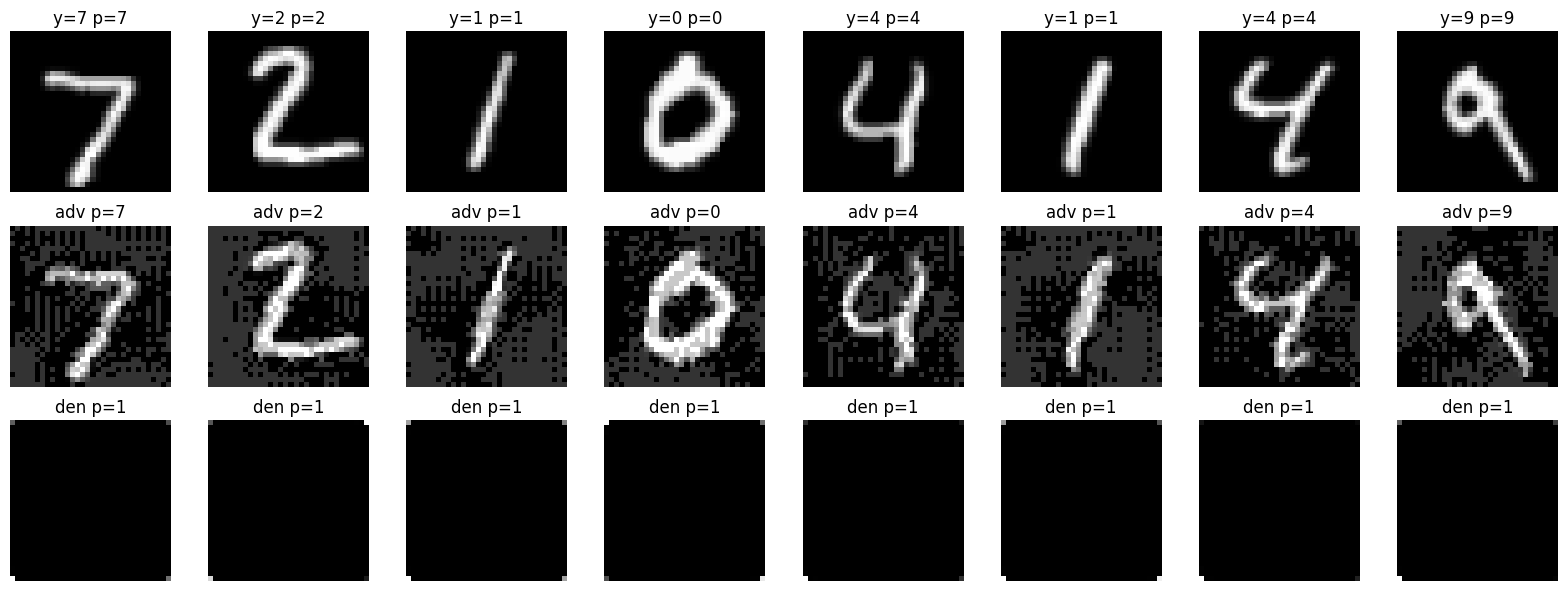


--- MyNet_ADV + AE samples ---


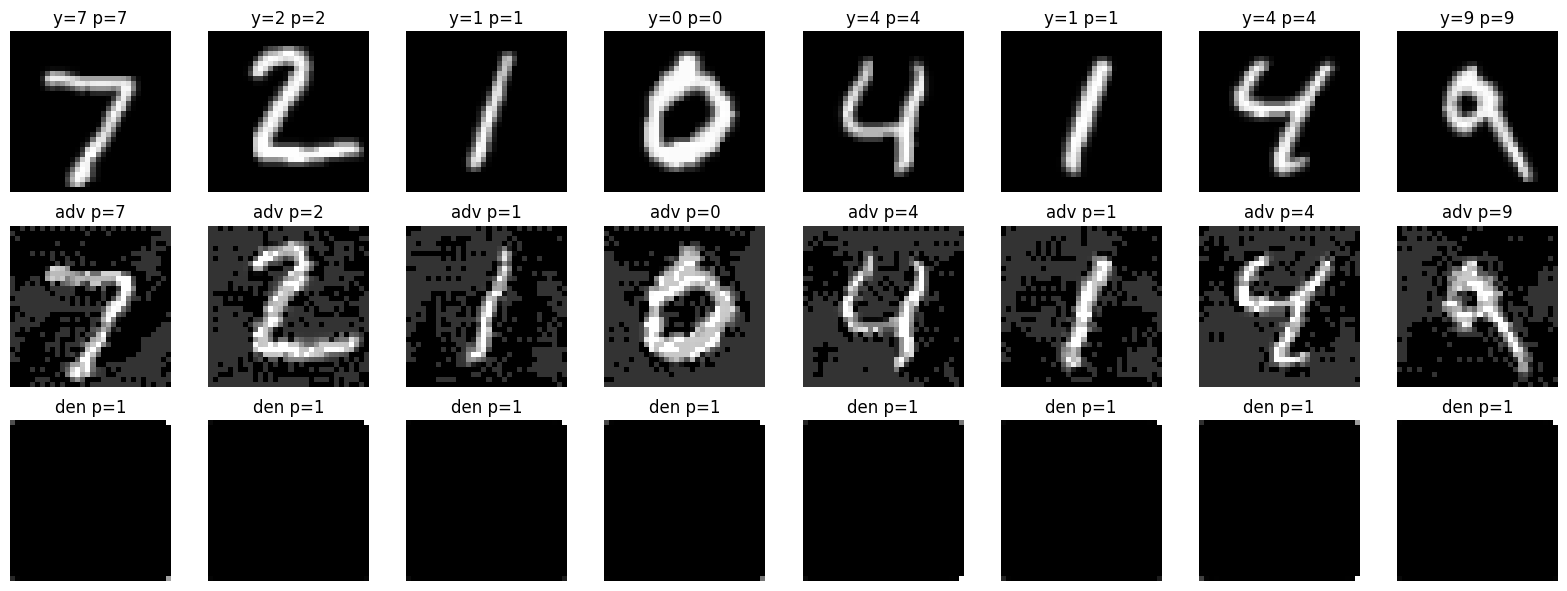

In [20]:
@torch.no_grad()
def show_triplet(classifier, ae, eps=0.2, n=8):
    classifier.eval(); ae.eval()
    x, y = next(iter(test_loader))
    x, y = x[:n].to(DEVICE), y[:n].to(DEVICE)

    with torch.enable_grad():
        x_adv = fgsm_attack(classifier, x, y, eps)
    x_den = ae(x_adv)

    p_clean = classifier(x).argmax(1)
    p_adv   = classifier(x_adv).argmax(1)
    p_den   = classifier(x_den).argmax(1)

    plt.figure(figsize=(2*n, 6))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(x[i,0].cpu(), cmap="gray"); plt.axis("off")
        plt.title(f"y={y[i].item()} p={p_clean[i].item()}")

        plt.subplot(3, n, n+i+1)
        plt.imshow(x_adv[i,0].cpu(), cmap="gray"); plt.axis("off")
        plt.title(f"adv p={p_adv[i].item()}")

        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(x_den[i,0].cpu(), cmap="gray"); plt.axis("off")
        plt.title(f"den p={p_den[i].item()}")
    plt.tight_layout(); plt.show()

print("\n--- VGG16_ADV + AE samples ---")
show_triplet(vgg_adv, ae_vgg, eps=maindata["fgsm_eps"], n=8)

print("\n--- MyNet_ADV + AE samples ---")
show_triplet(my_adv, ae_my, eps=maindata["fgsm_eps"], n=8)


## Fashion

In [ ]:
import struct
import gzip
from pathlib import Path

maindata["dataset"] = "fashion"
train_loader, test_loader, (MEAN, STD) = get_dataloaders(maindata["dataset"], maindata["mnist_path"], maindata["batch_size"])

def _open_maybe_gz(path: str):
    path = str(path)
    return gzip.open(path, "rb") if path.endswith(".gz") else open(path, "rb")

def _read_idx(path: str) -> np.ndarray:
    with _open_maybe_gz(path) as f:
        magic = f.read(4)
        if len(magic) != 4:
            raise RuntimeError(f"Bad IDX file (too short): {path}")
        zero1, zero2, dtype_code, ndim = struct.unpack(">BBBB", magic)
        if zero1 != 0 or zero2 != 0:
            raise RuntimeError(f"Bad IDX magic header: {path}")

        # dtype mapping (в Fashion/MNIST обычно uint8)
        dtype_map = {0x08: np.uint8, 0x09: np.int8, 0x0B: np.int16, 0x0C: np.int32, 0x0D: np.float32, 0x0E: np.float64}
        if dtype_code not in dtype_map:
            raise RuntimeError(f"Unsupported IDX dtype code {dtype_code} in {path}")
        dtype = dtype_map[dtype_code]

        dims = []
        for _ in range(ndim):
            dims.append(struct.unpack(">I", f.read(4))[0])

        data = f.read()
        arr = np.frombuffer(data, dtype=dtype)
        return arr.reshape(*dims)

def prepare_fashionmnist_processed(root: str):
    """
    root = путь до mnist_path (где лежит FashionMNIST/)
    Ожидает файлы в mnist_path/FashionMNIST/raw/ :
      train-images-idx3-ubyte  (или .gz)
      train-labels-idx1-ubyte  (или .gz)
      t10k-images-idx3-ubyte   (или .gz)
      t10k-labels-idx1-ubyte   (или .gz)
    Создаёт:
      mnist_path/FashionMNIST/processed/training.pt
      mnist_path/FashionMNIST/processed/test.pt
    """
    root = Path(root)
    raw_dir = root / "FashionMNIST" / "raw"
    proc_dir = root / "FashionMNIST" / "processed"
    proc_dir.mkdir(parents=True, exist_ok=True)

    # поддержим и .gz, и “распакованные” файлы
    def pick(name):
        p1 = raw_dir / name
        p2 = raw_dir / (name + ".gz")
        if p1.exists(): return p1
        if p2.exists(): return p2
        raise FileNotFoundError(f"Не найден файл {name} или {name}.gz в {raw_dir}")

    train_img = pick("train-images-idx3-ubyte")
    train_lbl = pick("train-labels-idx1-ubyte")
    test_img  = pick("t10k-images-idx3-ubyte")
    test_lbl  = pick("t10k-labels-idx1-ubyte")

    Xtr = _read_idx(train_img)   # (N, 28, 28)
    ytr = _read_idx(train_lbl)   # (N,)
    Xte = _read_idx(test_img)
    yte = _read_idx(test_lbl)

    # torchvision ожидает torch tensors (data uint8, targets int64)
    Xtr_t = torch.from_numpy(Xtr).to(torch.uint8)
    ytr_t = torch.from_numpy(ytr).to(torch.int64)
    Xte_t = torch.from_numpy(Xte).to(torch.uint8)
    yte_t = torch.from_numpy(yte).to(torch.int64)

    torch.save((Xtr_t, ytr_t), proc_dir / "training.pt")
    torch.save((Xte_t, yte_t), proc_dir / "test.pt")

    print("OK! Созданы файлы:")
    print(" -", proc_dir / "training.pt")
    print(" -", proc_dir / "test.pt")

prepare_fashionmnist_processed(maindata["mnist_path"])


OK! Созданы файлы:
 - mnist_path/FashionMNIST/processed/training.pt
 - mnist_path/FashionMNIST/processed/test.pt


/tmp/ipykernel_31167/4030830342.py:74: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  Xtr_t = torch.from_numpy(Xtr).to(torch.uint8)



=== TRAIN CLEAN: VGG16 ===


Epoch 01/6 | train acc=0.8117 loss=0.5642 | test acc=0.8802 loss=0.3541


Epoch 02/6 | train acc=0.8962 loss=0.3005 | test acc=0.8885 loss=0.3199


Epoch 03/6 | train acc=0.9122 loss=0.2499 | test acc=0.9067 loss=0.2616


Epoch 04/6 | train acc=0.9240 loss=0.2167 | test acc=0.9067 loss=0.2742


Epoch 05/6 | train acc=0.9319 loss=0.1931 | test acc=0.9142 loss=0.2310


Epoch 06/6 | train acc=0.9392 loss=0.1757 | test acc=0.9206 loss=0.2348


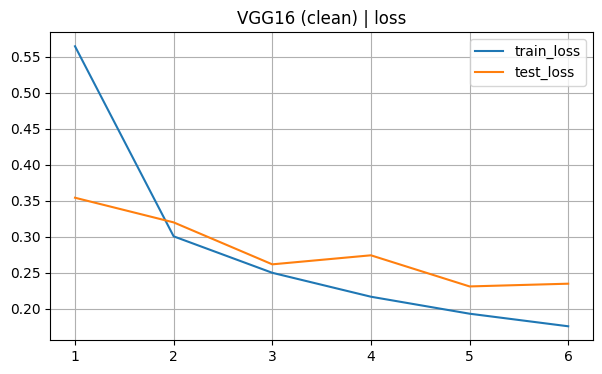

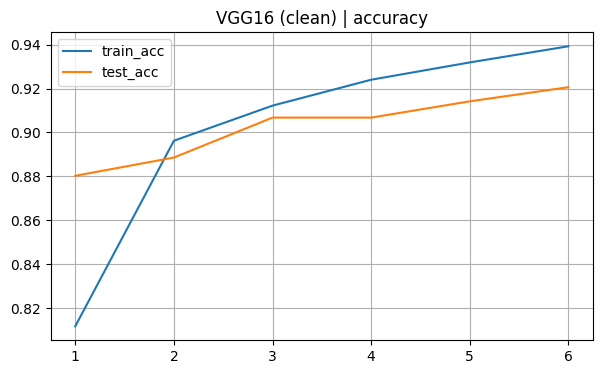


=== TRAIN CLEAN: MyNet ===


Epoch 01/6 | train acc=0.8481 loss=0.4444 | test acc=0.8749 loss=0.3591


Epoch 02/6 | train acc=0.9099 loss=0.2514 | test acc=0.8961 loss=0.2810


Epoch 03/6 | train acc=0.9233 loss=0.2115 | test acc=0.9073 loss=0.2488


Epoch 04/6 | train acc=0.9334 loss=0.1847 | test acc=0.9201 loss=0.2247


Epoch 05/6 | train acc=0.9404 loss=0.1645 | test acc=0.9195 loss=0.2307


Epoch 06/6 | train acc=0.9461 loss=0.1503 | test acc=0.9178 loss=0.2437


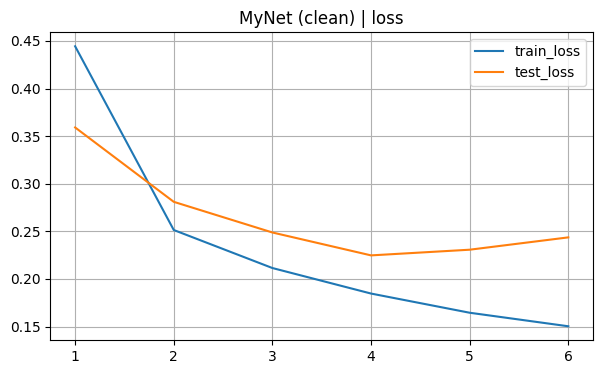

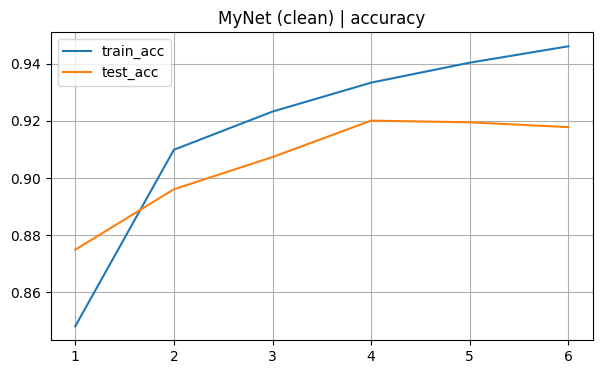


=== RESULTS (NO DEFENSE) ===
VGG16: clean=0.9206 | FGSM=0.0747
MyNet: clean=0.9178  | FGSM=0.0821


In [32]:
# обучаем на чистых данных
print("\n=== TRAIN CLEAN: VGG16 ===")
vgg16, hist_vgg = fit(vgg16, train_loader, test_loader, maindata["epochs_clean"], maindata["lr"])
plot_history(hist_vgg, "VGG16 (clean)")

print("\n=== TRAIN CLEAN: MyNet ===")
my_net, hist_my = fit(my_net, train_loader, test_loader, maindata["epochs_clean"], maindata["lr"])
plot_history(hist_my, "MyNet (clean)")

acc_vgg_clean = hist_vgg["test_acc"][-1]
acc_my_clean  = hist_my["test_acc"][-1]

# делаем ОТДЕЛЬНУЮ FGSM "базу" (на тесте) и меряем accuracy распознавания
vgg_fgsm_path = os.path.join(maindata["cache_dir"], f"fgsm_test_vgg_eps{maindata['fgsm_eps']:.2f}.pt")
my_fgsm_path  = os.path.join(maindata["cache_dir"], f"fgsm_test_my_eps{maindata['fgsm_eps']:.2f}.pt")

fgsm_test_ds_vgg = build_fgsm_dataset(vgg16, test_loader, maindata["fgsm_eps"], vgg_fgsm_path)
fgsm_test_ds_my  = build_fgsm_dataset(my_net, test_loader, maindata["fgsm_eps"], my_fgsm_path)

fgsm_test_loader_vgg = DataLoader(fgsm_test_ds_vgg, batch_size=maindata["batch_size"], shuffle=False, num_workers=0)
fgsm_test_loader_my  = DataLoader(fgsm_test_ds_my,  batch_size=maindata["batch_size"], shuffle=False, num_workers=0)

acc_vgg_fgsm = eval_on_loader(vgg16, fgsm_test_loader_vgg)
acc_my_fgsm  = eval_on_loader(my_net, fgsm_test_loader_my)

print("\n=== RESULTS (NO DEFENSE) ===")
print(f"VGG16: clean={acc_vgg_clean:.4f} | FGSM={acc_vgg_fgsm:.4f}")
print(f"MyNet: clean={acc_my_clean:.4f}  | FGSM={acc_my_fgsm:.4f}")



=== ADV TRAIN: VGG16 ===


[ADV] Epoch 01/4 | train acc=0.8693 loss=0.3812 | test acc=0.9095 loss=0.2639


[ADV] Epoch 02/4 | train acc=0.9424 loss=0.1779 | test acc=0.9001 loss=0.3241


[ADV] Epoch 03/4 | train acc=0.9523 loss=0.1470 | test acc=0.9133 loss=0.2520


[ADV] Epoch 04/4 | train acc=0.9561 loss=0.1332 | test acc=0.9220 loss=0.2299


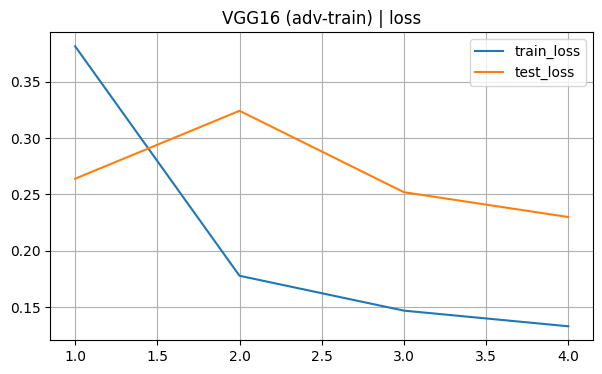

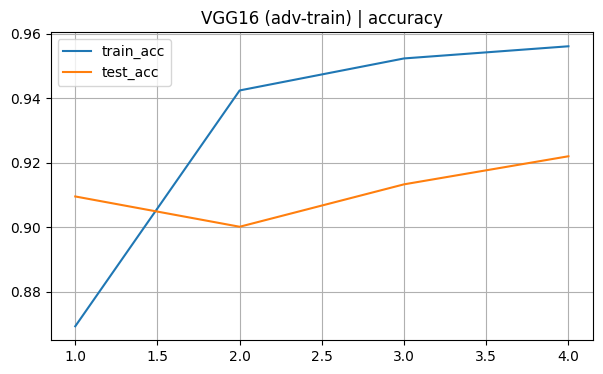


=== ADV TRAIN: MyNet ===


[ADV] Epoch 01/4 | train acc=0.8784 loss=0.3431 | test acc=0.9145 loss=0.2437


[ADV] Epoch 02/4 | train acc=0.9459 loss=0.1608 | test acc=0.9172 loss=0.2398


[ADV] Epoch 03/4 | train acc=0.9522 loss=0.1420 | test acc=0.9129 loss=0.2540


[ADV] Epoch 04/4 | train acc=0.9589 loss=0.1190 | test acc=0.9168 loss=0.2515


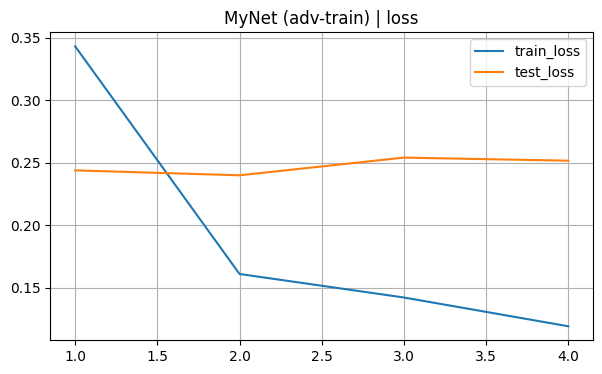

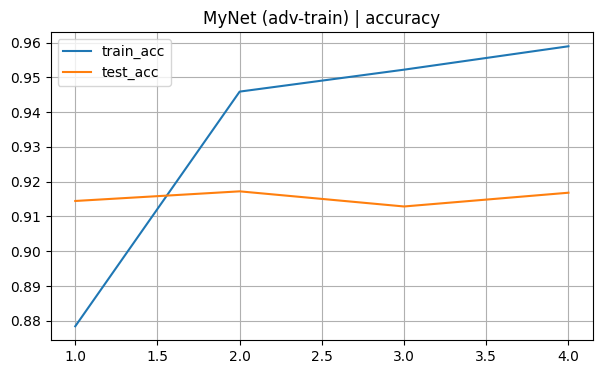


=== RESULTS (ADVERSARIAL TRAINING) ===
VGG16_ADV: clean=0.9220 | FGSM=0.0781
MyNet_ADV: clean=0.9168  | FGSM=0.1437


In [33]:
# копии моделей (чтобы не портить "чистую" версию)
vgg_adv = copy.deepcopy(vgg16)
my_adv  = copy.deepcopy(my_net)

print("\n=== ADV TRAIN: VGG16 ===")
vgg_adv, hist_vgg_adv = fit_advtrain(vgg_adv, train_loader, test_loader,
                                     maindata["epochs_advtrain"], maindata["lr"], maindata["fgsm_eps"])
plot_history(hist_vgg_adv, "VGG16 (adv-train)")

print("\n=== ADV TRAIN: MyNet ===")
my_adv, hist_my_adv = fit_advtrain(my_adv, train_loader, test_loader,
                                   maindata["epochs_advtrain"], maindata["lr"], maindata["fgsm_eps"])
plot_history(hist_my_adv, "MyNet (adv-train)")

# FGSM-база под защищённые модели (честнее — атаковать именно их)
vgg_adv_fgsm_path = os.path.join(maindata["cache_dir"], f"fgsm_test_vgg_adv_eps{maindata['fgsm_eps']:.2f}.pt")
my_adv_fgsm_path  = os.path.join(maindata["cache_dir"], f"fgsm_test_my_adv_eps{maindata['fgsm_eps']:.2f}.pt")

fgsm_test_ds_vgg_adv = build_fgsm_dataset(vgg_adv, test_loader, maindata["fgsm_eps"], vgg_adv_fgsm_path)
fgsm_test_ds_my_adv  = build_fgsm_dataset(my_adv,  test_loader, maindata["fgsm_eps"], my_adv_fgsm_path)

fgsm_test_loader_vgg_adv = DataLoader(fgsm_test_ds_vgg_adv, batch_size=maindata["batch_size"], shuffle=False, num_workers=0)
fgsm_test_loader_my_adv  = DataLoader(fgsm_test_ds_my_adv,  batch_size=maindata["batch_size"], shuffle=False, num_workers=0)

acc_vgg_adv_clean = hist_vgg_adv["test_acc"][-1]
acc_my_adv_clean  = hist_my_adv["test_acc"][-1]
acc_vgg_adv_fgsm  = eval_on_loader(vgg_adv, fgsm_test_loader_vgg_adv)
acc_my_adv_fgsm   = eval_on_loader(my_adv,  fgsm_test_loader_my_adv)

print("\n=== RESULTS (ADVERSARIAL TRAINING) ===")
print(f"VGG16_ADV: clean={acc_vgg_adv_clean:.4f} | FGSM={acc_vgg_adv_fgsm:.4f}")
print(f"MyNet_ADV: clean={acc_my_adv_clean:.4f}  | FGSM={acc_my_adv_fgsm:.4f}")

In [34]:
# AE для VGG16_ADV
ae_vgg = DenoiseAE(in_ch=1, latent_noise=0.05)
ae_vgg = train_ae(ae_vgg, vgg_adv, train_loader, maindata["fgsm_eps"], epochs=maindata["epochs_ae"], lr=1e-3)
def_vgg = defense_fn_from_ae(ae_vgg)
acc_vgg_adv_fgsm_denoised = eval_on_loader(vgg_adv, fgsm_test_loader_vgg_adv, defense_fn=def_vgg)

# AE для MyNet_ADV
ae_my = DenoiseAE(in_ch=1, latent_noise=0.05)
ae_my = train_ae(ae_my, my_adv, train_loader, maindata["fgsm_eps"], epochs=maindata["epochs_ae"], lr=1e-3)
def_my = defense_fn_from_ae(ae_my)
acc_my_adv_fgsm_denoised = eval_on_loader(my_adv, fgsm_test_loader_my_adv, defense_fn=def_my)

print("\n=== RESULTS (DENOISING AE on top of ADV-TRAIN) ===")
print(f"VGG16_ADV + AE: FGSM->denoised acc={acc_vgg_adv_fgsm_denoised:.4f}")
print(f"MyNet_ADV + AE: FGSM->denoised acc={acc_my_adv_fgsm_denoised:.4f}")

AE epoch 01/6 | mse=0.016357


AE epoch 02/6 | mse=0.005542


AE epoch 03/6 | mse=0.004718


AE epoch 04/6 | mse=0.004193


AE epoch 05/6 | mse=0.003814


AE epoch 06/6 | mse=0.003564


AE epoch 01/6 | mse=0.016356


AE epoch 02/6 | mse=0.005512


AE epoch 03/6 | mse=0.004802


AE epoch 04/6 | mse=0.004316


AE epoch 05/6 | mse=0.003965


AE epoch 06/6 | mse=0.003707

=== RESULTS (DENOISING AE on top of ADV-TRAIN) ===
VGG16_ADV + AE: FGSM->denoised acc=0.1260
MyNet_ADV + AE: FGSM->denoised acc=0.1272



--- VGG16_ADV + AE samples ---


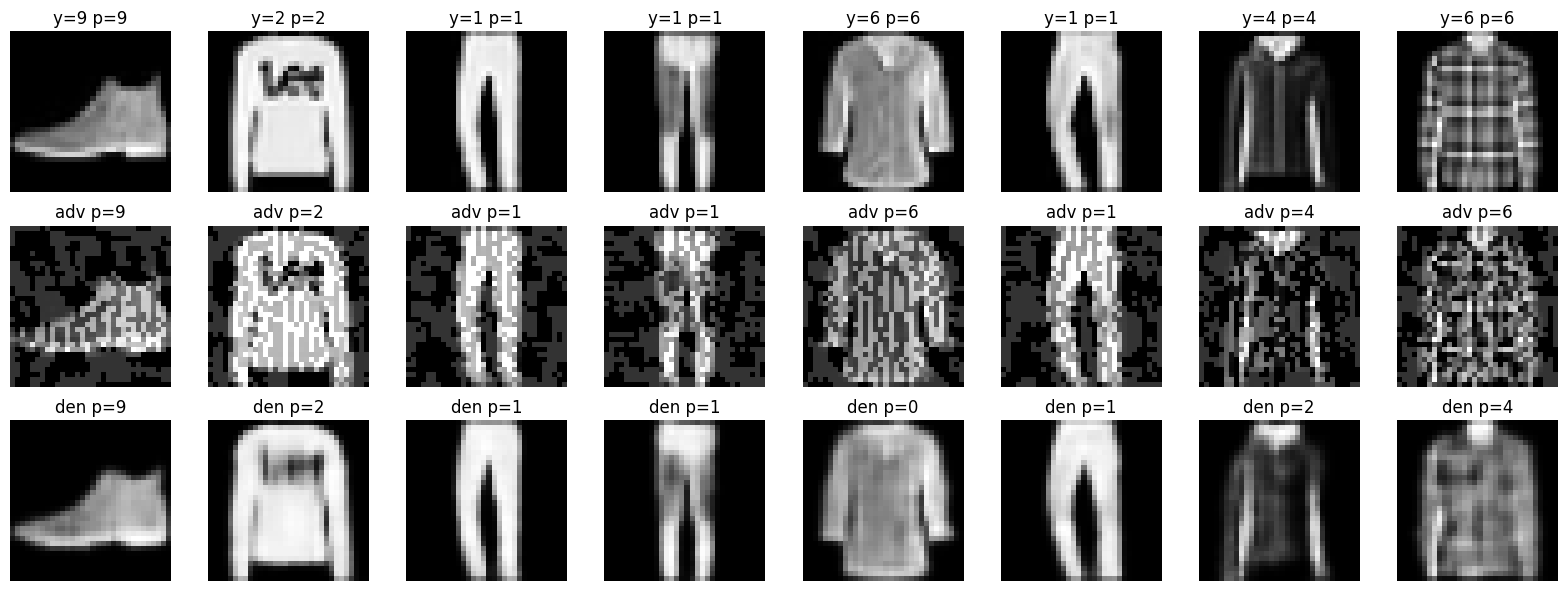


--- MyNet_ADV + AE samples ---


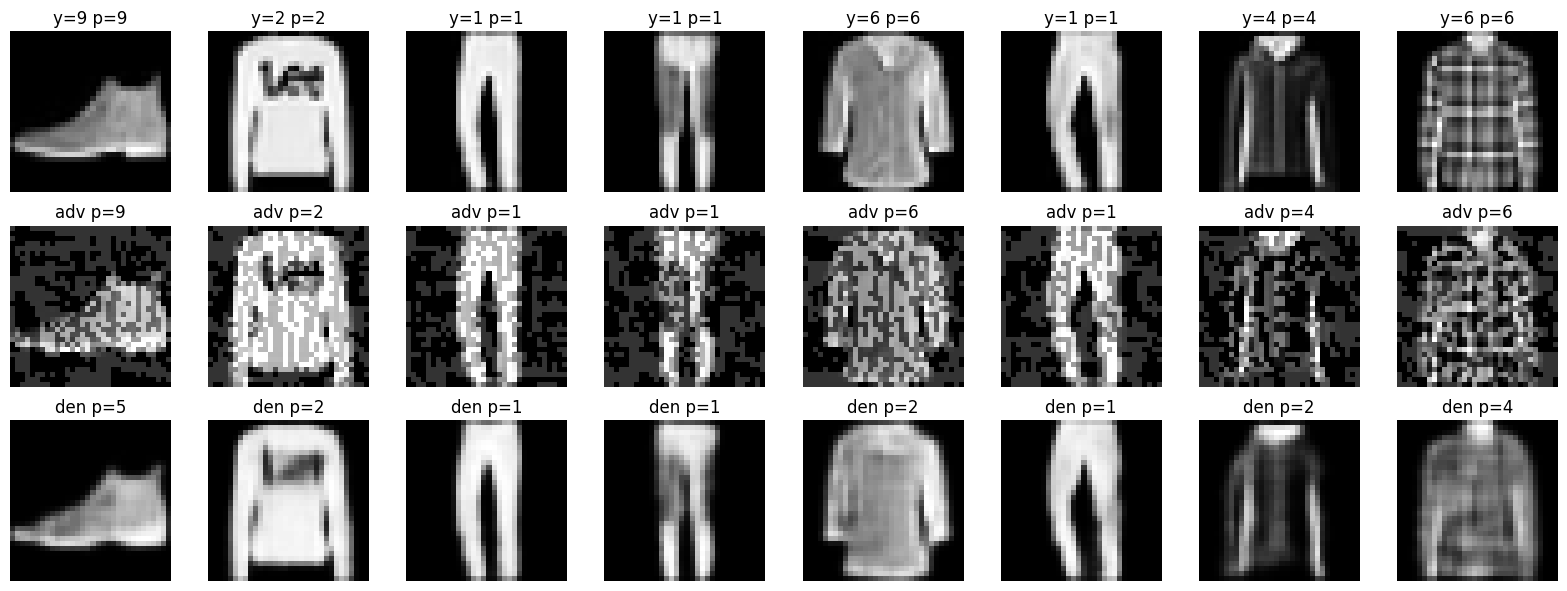

In [35]:
@torch.no_grad()
def show_triplet(classifier, ae, eps=0.2, n=8):
    classifier.eval(); ae.eval()
    x, y = next(iter(test_loader))
    x, y = x[:n].to(DEVICE), y[:n].to(DEVICE)

    with torch.enable_grad():
        x_adv = fgsm_attack(classifier, x, y, eps)
    x_den = ae(x_adv)

    p_clean = classifier(x).argmax(1)
    p_adv   = classifier(x_adv).argmax(1)
    p_den   = classifier(x_den).argmax(1)

    plt.figure(figsize=(2*n, 6))
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(x[i,0].cpu(), cmap="gray"); plt.axis("off")
        plt.title(f"y={y[i].item()} p={p_clean[i].item()}")

        plt.subplot(3, n, n+i+1)
        plt.imshow(x_adv[i,0].cpu(), cmap="gray"); plt.axis("off")
        plt.title(f"adv p={p_adv[i].item()}")

        plt.subplot(3, n, 2*n+i+1)
        plt.imshow(x_den[i,0].cpu(), cmap="gray"); plt.axis("off")
        plt.title(f"den p={p_den[i].item()}")
    plt.tight_layout(); plt.show()

print("\n--- VGG16_ADV + AE samples ---")
show_triplet(vgg_adv, ae_vgg, eps=maindata["fgsm_eps"], n=8)

print("\n--- MyNet_ADV + AE samples ---")
show_triplet(my_adv, ae_my, eps=maindata["fgsm_eps"], n=8)
